# scRNA-Seq dataset  [Hor et al. (2020)](https://www.sciencedirect.com/science/article/pii/S2589004220302686?via%3Dihub)
Efficient generation and transcriptomic profiling of human iPSC-derived pulmonary neuroendocrine cells

## Imports

In [1]:
import pandas as pd
import numpy as np
import os, tqdm
import scanpy as sc
from anndata import AnnData
import hdf5plugin
import anndata as ad
from scipy.sparse import csr_matrix
import pandas as pd
from itertools import combinations
import celltypist
from celltypist import models

## Figure Settings

In [2]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Custom colormap

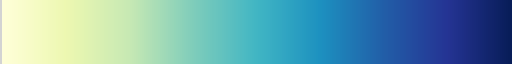

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

## Inspect matrixes AnnData

In [4]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")

## Merging raw scRNA-Seq data from different donors

In [4]:
adata_1=sc.read_10x_h5("./data/Hor2020/GSE146990_iPSdiff_1_filtered_gene_bc_matrices_h5.h5")
adata_1.var['gencode_og_name']=adata_1.var_names
adata_1.var_names=adata_1.var['gene_ids']
adata_1.obs['Sample ID']= 'iPSdiff_1'
adata_1.obs['Patient ID']= 'iPSdiff_1'
adata_1

AnnData object with n_obs × n_vars = 2118 × 33694
    obs: 'Sample ID', 'Patient ID'
    var: 'gene_ids', 'gencode_og_name'

In [5]:
adata_2=sc.read_10x_h5("./data/Hor2020/GSE146990_iPSdiff_2_filtered_gene_bc_matrices_h5.h5")
adata_2.var['gencode_og_name']=adata_2.var_names
adata_2.var_names=adata_1.var['gene_ids']
adata_2.obs['Sample ID']= 'iPSdiff_2'
adata_2.obs['Patient ID']= 'iPSdiff_2'
adata_2

AnnData object with n_obs × n_vars = 2039 × 33694
    obs: 'Sample ID', 'Patient ID'
    var: 'gene_ids', 'gencode_og_name'

In [6]:
# Concatenating ADATAs
merged_adata = ad.concat([adata_1, adata_2],join='outer',merge= 'unique',axis=0)
merged_adata

AnnData object with n_obs × n_vars = 4157 × 33694
    obs: 'Sample ID', 'Patient ID'
    var: 'gene_ids', 'gencode_og_name'

In [7]:
merged_adata.obs['Tissue'] = 'iPNECs'
merged_adata.obs['Study']= 'Hor et al., (2020)'
merged_adata.obs['Time point']= 'day 91 (ALI)'

#### Saving merged *AnnData*

In [8]:
merged_adata.write_h5ad('./data/Hor2020/Hor_2020_iPNECs.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

... storing 'Sample ID' as categorical
... storing 'Patient ID' as categorical
... storing 'Tissue' as categorical
... storing 'Study' as categorical
... storing 'Time point' as categorical
... storing 'gencode_og_name' as categorical


## Gene Annotation

We want to be able to merge this data with ours to compare them. 

First we need to make sure genes are annotated the same way in both datasets.

In [22]:
adata_ipnecs=sc.read_h5ad('./data/Hor2020/Hor_2020_iPNECs.h5ad')
adata_ipnecs

AnnData object with n_obs × n_vars = 4157 × 33694
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
    var: 'gene_ids', 'gencode_og_name'

In [23]:
adata_ipnecs.var.rename(
    mapper= {'gene_ids' : 'gencode_og_id'},
    axis= 1,
    inplace= True
)
adata_ipnecs.var

,gencode_og_id,gencode_og_name
gene_ids,,
ENSG00000243485,ENSG00000243485,RP11-34P13.3
ENSG00000237613,ENSG00000237613,FAM138A
ENSG00000186092,ENSG00000186092,OR4F5
ENSG00000238009,ENSG00000238009,RP11-34P13.7
ENSG00000239945,ENSG00000239945,RP11-34P13.8
...,...,...
ENSG00000277856,ENSG00000277856,AC233755.2
ENSG00000275063,ENSG00000275063,AC233755.1
ENSG00000271254,ENSG00000271254,AC240274.1


In [24]:
# Fxn to parse gencode annotation into dict
def gencode_parser(filepath):
    # Use regular expressions to find gene_id and gene_name regardless of number of columns in input annotation
    import re
    # gene_id_pattern = re.compile(r'gene_id\s+"([^"]+)"')
    gene_id_pattern = re.compile(r'gene_id\s+"(ENSG[0-9]+)')
    gene_name_pattern = re.compile(r'gene_name\s+"([^"]+)"')

    with open(filepath, 'r') as f:
        gtf = {
            gene_id_pattern.search(line).group(1) : gene_name_pattern.search(line).group(1)
            for line in f
            if not line.startswith('#')
        }
    return gtf
gtf_annots = gencode_parser('./data/annotations_aux_files/gencode.v44.annotation.gtf')

In [25]:
# We now map the original ENS_ID to the v44 ENS_ID's gene name
adata_ipnecs.var['gencode_v44_name'] = adata_ipnecs.var['gencode_og_id'].replace(gtf_annots)
# We make this v44 names the index for the data
adata_ipnecs.var_names = adata_ipnecs.var['gencode_v44_name']
del gtf_annots
adata_ipnecs.var

,gencode_og_id,gencode_og_name,gencode_v44_name
gencode_v44_name,,,
MIR1302-2HG,ENSG00000243485,RP11-34P13.3,MIR1302-2HG
FAM138A,ENSG00000237613,FAM138A,FAM138A
OR4F5,ENSG00000186092,OR4F5,OR4F5
ENSG00000238009,ENSG00000238009,RP11-34P13.7,ENSG00000238009
ENSG00000239945,ENSG00000239945,RP11-34P13.8,ENSG00000239945
...,...,...,...
ENSG00000277856,ENSG00000277856,AC233755.2,ENSG00000277856
ENSG00000275063,ENSG00000275063,AC233755.1,ENSG00000275063
ENSG00000271254,ENSG00000271254,AC240274.1,ENSG00000271254


In [26]:
# Count NaN values in the 'features' column
int(adata_ipnecs.var['gencode_v44_name'].isna().sum())

0

### Handling duplicated gene entries

We now have to make sure there are no duplicates.

**Why could there be duplicates?** 

> Because one gene could have the same gene name with two different ENS_IDs in the original dataset.

In [27]:
# Display duplicated entries
duplicate_var_names = adata_ipnecs.var_names[adata_ipnecs.var_names.duplicated()]
adata_ipnecs.var_names.name = None
adata_ipnecs.var.loc[duplicate_var_names, :].sort_index()

,gencode_og_id,gencode_og_name,gencode_v44_name
gencode_v44_name,,,
DNAJC9-AS1,ENSG00000236756,DNAJC9-AS1,DNAJC9-AS1
DNAJC9-AS1,ENSG00000227540,RP11-152N13.5,DNAJC9-AS1
GOLGA8M,ENSG00000261480,RP11-578F21.6,GOLGA8M
GOLGA8M,ENSG00000188626,GOLGA8M,GOLGA8M
GPR84-AS1,ENSG00000258086,RP11-753H16.5,GPR84-AS1
GPR84-AS1,ENSG00000258137,RP11-753H16.3,GPR84-AS1
ITFG2-AS1,ENSG00000258325,RP4-816N1.6,ITFG2-AS1
ITFG2-AS1,ENSG00000256150,RP11-885B4.1,ITFG2-AS1
LINC00484,ENSG00000229694,RP11-305L7.6,LINC00484


**NOTICE:** Different Original ENS_IDs but same name

**Generate**
- AnnData with only duplicated entries

In [28]:
# Filter by duplicated var_names
adata_dup = adata_ipnecs[:, adata_ipnecs.var['gencode_v44_name'].isin(duplicate_var_names)].copy()
adata_dup

AnnData object with n_obs × n_vars = 4157 × 34
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
    var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name'

In [29]:
# We will split the duplicated var_names object into doublets for each unique var_name
duplicates_dict = {}
duplicates_names = list(adata_dup.var_names)
for var_name in duplicates_names:
    duplicates_dict[var_name] = adata_dup[:, var_name]

del duplicates_names
del var_name
duplicates_dict

{'LINC01115': View of AnnData object with n_obs × n_vars = 4157 × 2
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name',
 'LINC01238': View of AnnData object with n_obs × n_vars = 4157 × 2
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name',
 'PRICKLE2-AS1': View of AnnData object with n_obs × n_vars = 4157 × 2
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name',
 'MATR3': View of AnnData object with n_obs × n_vars = 4157 × 2
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name',
 'RAET1E-AS1': View of AnnData object with n_obs × n_vars = 4157 × 2
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'genc

**NOTICE:** in order to have only one entry for each unique gene, we will sum both their counts value

We will recreate an AnnData object for each duplicated entry with the collpased data and merged metadata

In [31]:
ann_data_dict_sum = {}

for anndata_key, anndata_value in duplicates_dict.items():
    var_name = anndata_key
    
    # Sum the expression values for genes for the current AnnData object 
    summed_expression = csr_matrix(anndata_value.X.sum(axis= 1))                     
    
    # Create a new AnnData object to store the summed expression and all merged metadata
    ann_data_dict_sum[anndata_key] = ad.AnnData(
        X = summed_expression,
        obs= anndata_value.obs.copy(),
        var= {
            'gencode_og_id' : ', '.join(list(map(str, set(anndata_value.var.loc[:, 'gencode_og_id'])))),
            'gencode_og_name' : ', '.join(list(map(str, set(anndata_value.var.loc[:, 'gencode_og_name'])))),
            'gencode_v44_name' : ', '.join(list(map(str, set(anndata_value.var.loc[:, 'gencode_v44_name'])))),
            'summed_genes' : True
        },
    )
    # Specify a new name for the collapsed gene axis
    ann_data_dict_sum[anndata_key].var_names = [var_name]

# # NOTICE: this dataset has cell IDs that can be duplicated, which creates an error when concatenating
print(ann_data_dict_sum[next(iter(ann_data_dict_sum))].obs_names[:10])
# We need to make these unique for each duplicated gene anndata
for ann in ann_data_dict_sum.values():
    ann.obs_names = ann.obs_names.astype(str)
    ann.obs_names_make_unique()

adata_summed_dups = ad.concat(
    list(ann_data_dict_sum.values()),
    axis= 1,
    join= 'outer',
    merge= 'unique'
)

# Remove all objects we no longer need
del duplicates_dict
del anndata_value
del anndata_key
del summed_expression
del var_name
del ann_data_dict_sum
del adata_dup

adata_summed_dups

Index(['AAACCTGAGCACACAG-1', 'AAACCTGCACGAAATA-1', 'AAACCTGGTGCCTGTG-1',
       'AAACCTGGTTATCACG-1', 'AAACCTGTCCTTAATC-1', 'AAACCTGTCGTTTGCC-1',
       'AAACGGGAGAGAGCTC-1', 'AAACGGGAGATGCGAC-1', 'AAACGGGAGGACTGGT-1',
       'AAACGGGCATGGTAGG-1'],
      dtype='object')


AnnData object with n_obs × n_vars = 4157 × 17
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
    var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes'

In [32]:
# Filter out duplicated var_names
adata_unique = adata_ipnecs[:, ~adata_ipnecs.var['gencode_v44_name'].isin(duplicate_var_names)].copy()
adata_unique.var['summed_genes'] = False
adata_unique.obs_names = adata_unique.obs_names.astype(str)
adata_unique.obs_names_make_unique()

adata_unique, bool(adata_unique.var_names.duplicated().any())

(AnnData object with n_obs × n_vars = 4157 × 33660
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes',
 False)

We concat both AnnData objects to have a final one without duplicates and with full metadata

In [33]:
adata_final = ad.concat(
    [adata_unique, adata_summed_dups],
    axis= 1,
    join= 'outer',
    merge= 'unique'
)
del adata_unique
del adata_summed_dups

adata_final

AnnData object with n_obs × n_vars = 4157 × 33677
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
    var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes'

In [34]:
adata_ipnecs, adata_final

(AnnData object with n_obs × n_vars = 4157 × 33694
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name',
 AnnData object with n_obs × n_vars = 4157 × 33677
     obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
     var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes')

In [35]:
# Write to data directory our annotated AnnData
adata_final.write_h5ad(
    './data/Hor2020/Hor2020_iPNECs_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

del adata_ipnecs
del adata_final

... storing 'gencode_og_name' as categorical


# Celltypist - Neuroendocrine cells annotataion

In [5]:
adata = sc.read_h5ad('./data/Hor2020/Hor2020_iPNECs_annotated.h5ad')
adata.raw = adata.copy()
adata.layers['counts'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 4157 × 33677
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point'
    var: 'gencode_og_id', 'gencode_og_name', 'gencode_v44_name', 'summed_genes'
    layers: 'counts'

In [6]:
matrix_summary(adata)

Expression matrix (X): min=0.0, max=4406.0, mean=0.2709001302719116
Counts layer matrix (layers['counts']): min=0.0, max=4406.0, mean=0.2709001302719116
Raw matrix (raw.X): min=0.0, max=4406.0, mean=0.2709001302719116
Scaled layer not found in adata.layers.


In [7]:
# Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data matrix.
# Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata)

adata.raw = adata.copy()

In [8]:
matrix_summary(adata)

Expression matrix (X): min=0.0, max=8.404047012329102, mean=0.09322400391101837
Counts layer matrix (layers['counts']): min=0.0, max=4406.0, mean=0.2709001302719116
Raw matrix (raw.X): min=0.0, max=8.404047012329102, mean=0.09322400391101837
Scaled layer not found in adata.layers.


In [9]:
predictions = celltypist.annotate(adata, model = './data/Celltypist/celltypist_costum_models/Human_Lung_celltype.pkl',   
                                  majority_voting = True,mode = 'best match')

🔬 Input data has 4157 cells and 33677 genes
🔗 Matching reference genes in the model
🧬 2942 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
2026-01-07 23:59:57.669136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-07 23:59:57.669199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-07 23:59:57.671087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-07 23:59:59.269167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning

In [10]:
predictions

CellTypist prediction result for 4157 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 4157 query cells and 22 cell types
    probability_matrix: data frame with 4157 query cells and 22 cell types
    adata: AnnData object referred

In [11]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata(insert_prob = True)
adata.obs['majority_voting']

AAACCTGAGCACACAG-1    Basal
AAACCTGCACGAAATA-1    Basal
AAACCTGGTGCCTGTG-1    Basal
AAACCTGGTTATCACG-1    Basal
AAACCTGTCCTTAATC-1    Basal
                      ...  
TTTGTCAAGCAATCTC-1    Basal
TTTGTCAGTTCTCATT-1    Basal
TTTGTCATCGTCCAGG-1    Basal
TTTGTCATCGTGGACC-1     PNEC
TTTGTCATCTCAACTT-1    Basal
Name: majority_voting, Length: 4157, dtype: category
Categories (6, object): ['AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'PNEC']

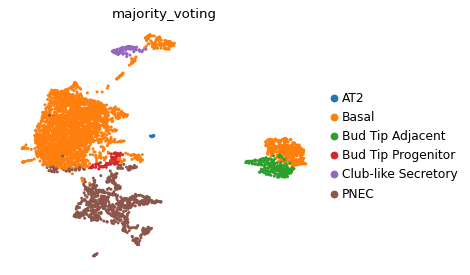

In [12]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='majority_voting')

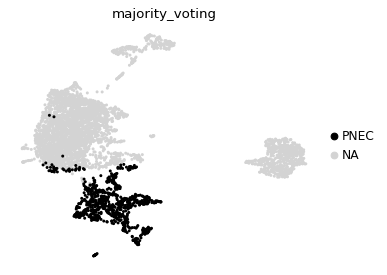

In [13]:
sc.pl.umap(adata, color='majority_voting', groups=['PNEC'], palette=['black'],save='_iPNECs_celltypist_Neuroendocrine')

In [14]:
adata.write_h5ad('./data/Hor2020/Hor2020_iPNECs_processed.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)